40 min to run

In [1]:
import torch
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import random
import sys
sys.path.append("..")
from inference import GaussMarkovLagrange
from likelihoods import Gaussian
from mappings import AffineMapping
from transition import FixedPointSparseGP, SparseGP
from kernels import RBF
from models import GPSDEmodel, GPSDE

In [2]:
# set random seeds
np.random.seed(10)
random.seed(10)

def doubleWell(x):
    # true double well dynamics
    return 4 * x * (1 - x**2)

def simulate_sde(f, x0, tmax, dt, sigma=1.):
    # function to simulate the SDE
    x = np.array([x0])
    N = int(tmax / dt)
    for i in range(N - 1):
        x = np.append(x, x[i] + f(x[i]) * dt + np.sqrt(sigma * dt) * np.random.randn(1))
    return x

def generate_indices(dtmin,iimax,nsamps):
    # function to sample indices for random time points where observations are made        
    tidx = np.sort(random.sample(range(0,iimax), nsamps))
    
    for ii in range(nsamps-1):
        if tidx[ii+1] - tidx[ii] < dtmin:
            tidx[ii+1] += dtmin
        
        if tidx[ii+1] > iimax:
            tidx[ii+1] = iimax
        
    return np.sort(tidx)

# Double well dynamics
This example simulates data from a model where a latent process $x(t)$ evolves according to a stochastic differential equation of the form
$$
d x(t) = f(x) dt + \sqrt{\sigma} dW(t)
$$
where $W(t)$ is a Wiener noise process and the drift is given by 
$$
f(x) = 4 x (1 - x^2)
$$

The latent process relates to the higher-dimensional observations $\mathbf{y}(t) \in \mathbb{R}^N$ as
$$
y_n(t_i) = c_n \; x(t_i) + d_n + \epsilon_n , \qquad n = 1,\dots N
$$
with $\epsilon_n \sim \mathcal{N}(0, \nu_n^2)$. The $t_i$ are the time points when observations are sampled, which can be uneven and do not have to lie on a grid.

In [3]:
tmax = 3                        # maximum duration for a trial
yDim = 15                       # number of output dimensions
nTrials = 10                    # number of trials
trLen = tmax * np.ones(nTrials) # duration in seconds of each trial

# output mapping parameters
C = 2.0*np.random.rand(yDim,1) * np.random.choice([-1,1],size=(yDim,1))
d = 0.2*np.random.randn(yDim,1)

# standard deviation of independent noise at output level
sig = 0.5

# sample dense paths
xpath = []      # latent process
Ydense = []     # observation process

# sample each trial at 1ms discretisation
for n in range(nTrials):
    xpath.append(simulate_sde(doubleWell, 0, trLen[n], 0.001, 1.5)) # 1ms binning 
    Ydense.append(C * xpath[n] + d + sig * np.random.randn(yDim,int(tmax/0.001)))


nsamps = 20      # number of observed samples of the output process per trial
tgrid = np.linspace(0, tmax, int(tmax/0.001)) # location of dense observations

tIdx = [np.sort(random.sample(range(1,int(tmax/0.001)), nsamps)) for _ in range(nTrials)]
tidx = [generate_indices(80,int(tmax/0.001),nsamps) for _ in range(nTrials)]

tObs = [tgrid[tIdx[idx]] for idx in range(nTrials)]
Y = [Ydense[idx][:,tIdx[idx]].transpose() for idx in range(nTrials)]


## Visualise synthetic data

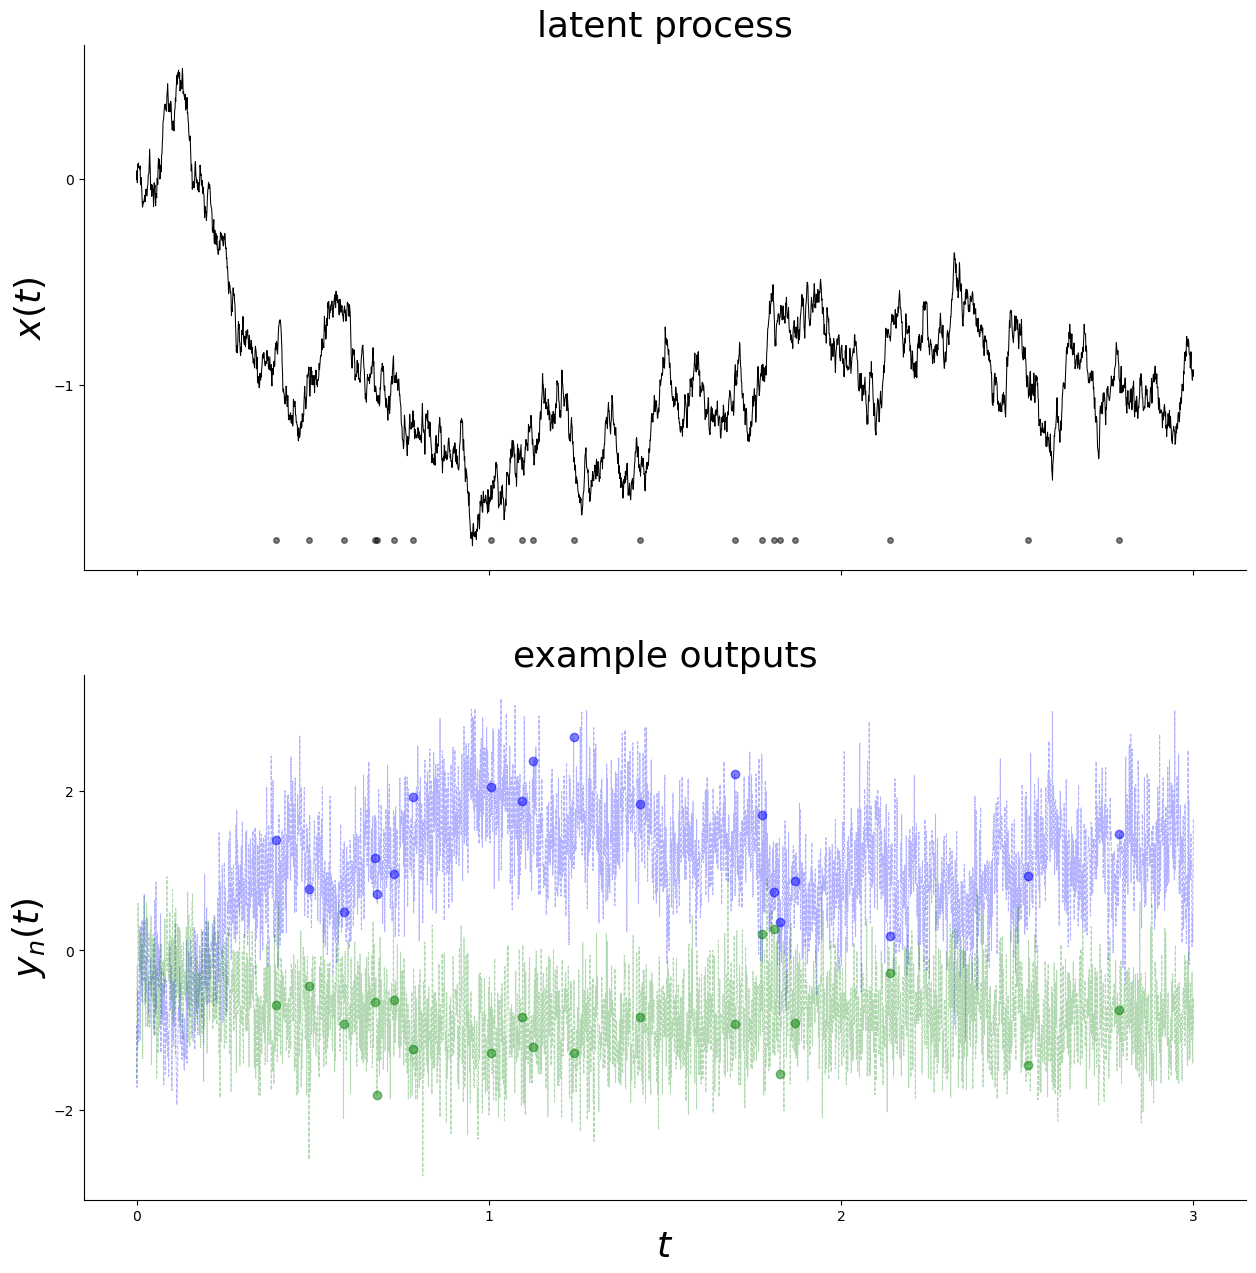

In [4]:
# plot example trial
idx = 4 # trial index
testTimes = torch.linspace(0,trLen[idx],int(trLen[idx]/0.001)).type(torch.float64)
mkrsz = 6

ii1 = 7 # index of output 1 
ii2 = 5 # index of output 2

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.set_figheight(15)
f.set_figwidth(15)
ax1.plot(testTimes.numpy(),xpath[idx],color='black',linewidth=0.75)

# plot where observations lie
ax1.plot(tObs[idx],-1.75*np.ones_like(tObs[idx]),'k.',alpha=0.5, markersize=mkrsz+2, label='$y_1(t_i)$')

ax1.locator_params(nbins=4)
ax1.set_ylabel('$x(t)$',fontsize=26)
ax1.set_title('latent process',fontsize=26)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)

# plot dense observations process
ax2.plot(testTimes.numpy(),Ydense[idx][ii1,:],'b--',linewidth=0.75,alpha=0.3, label='$y_1(t)$')
ax2.plot(testTimes.numpy(),Ydense[idx][ii2,:],'g--',linewidth=0.75,alpha=0.3, label='$y_2(t)$')

# plot sparse samples
ax2.plot(tObs[idx],Y[idx][:,ii1],'bo',alpha=0.5, markersize=mkrsz, label='$y_1(t_i)$')
ax2.plot(tObs[idx],Y[idx][:,ii2],'go',alpha=0.5, markersize=mkrsz, label='$y_2(t_i)$')
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.locator_params(nbins=4)
ax2.set_ylabel('$y_n(t)$',fontsize=26)
ax2.set_xlabel('$t$',fontsize=26)
ax2.set_title('example outputs',fontsize=26)

plt.show()


# Building a GP-SDE model

Now that we have the dataset, we can build a GP-SDE model in order to do inference and learn the SDE dynamics. There are a few core ingrendients to the model that need to be specified.


In [5]:
dtgrid = 0.001 # time grid used for inference 
xDim = 1       # latent dimensionality

### Observation likelihood 
In this example we choose a Gaussian likelihood, which takes as input the value `Y` and time stamp `tObs` of the observations. We also need to initialise the diagonal noise covariance `R0`.

In [6]:
R0 = 1. * torch.ones(yDim,1) # diagonal noise covariance of output 
like = Gaussian(Y, tObs, trLen, R0, dtstep=dtgrid, useClosedForm=True) # likelihood

c:\Users\fosmo\OneDrive\Documents\GitHub\gp-sde\demos\..\utils.py:385: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  ..\aten\src\ATen/native/IndexingUtils.h:30.)
  Ybin[obsMask.unsqueeze(-1).expand(Ybin.size())] = Y.view(-1)


### Mapping from latents to observations
We choose an Affine mapping from latents to observations and initialise it at the true generative parameters.
Given the Gaussian likelihood, we can also utilise closed form updates (for other likelihoods this will raise an error and you should use `useClosedForm=False`)

In [7]:
# affine output mapping initialised at generative parameters
outputMapping = AffineMapping(torch.tensor(C).permute(1, 0), torch.tensor(d).permute(1, 0), useClosedForm=True) 

### The drift function
We model the SDE drift nonparametrically using a Gaussian Process. Because we are interested in extracting interpretable features of the dynamics, we condition out Gaussian Process prior on fixed point locations and Jacobian values around the fixed points. We have to choose a a covariance kernel `kern` with lengthscales `lens`, the number `numZ` and location `Zs` of inducing points, as well as the (initial) number and location of the fixed points `Zs_fx`.

In [8]:
# RBF kernel for the Gaussian Process prior, with lengthscales 
lens = torch.tensor([0.25]).reshape(-1,1).type(torch.float64)
kern = RBF(xDim,lens) 
numZ = 8 # number of inducing points 
Zs = torch.linspace(-3,3,numZ).unsqueeze(-1) # space inducing points on a grid
Zs_fx = torch.tensor([-1., -0.4, 0., 1.]).view(-1,xDim) # fixed point locations

# specify the transition function
# transfunc = SparseGP(kern, Zs) # vanilla sparse Gaussian Process transition function 
transfunc = FixedPointSparseGP(kern, Zs, Zs_fx) # sparse Gaussian Process transition function conditioned on fixed pts

c:\Users\fosmo\OneDrive\Documents\GitHub\gp-sde\demos\..\transition.py:893: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ..\aten\src\ATen\native\BatchLinearAlgebra.cpp:766.)
  Kdd_inv_Kdz, _ = torch.solve(Kdz, Kdd)


### Inference algorithm
We use variational inference with a Gaussian approximation that preserves the Markov structure of the true posterior.

In [9]:
# specify inference algorithm
inference = GaussMarkovLagrange(xDim, trLen, learningRate=1, dtstep=dtgrid)

## Final model
Now we have all the pieces to build up the final model as

In [10]:
# put everything tobgether into a model
model = GPSDEmodel(xDim, transfunc, outputMapping, like, nLeg=100)

# create GPSDE model object 
myGPSDE = GPSDE(model, inference)

# Train the model
The model is trained using variational EM. If there are parameters we don't want to update, simply set `.requires_grad=False`. We do this for the inducing point locations to hold them fixed on the grid we have specified above. By default, the optimiser uses the native pytorch L-BFGS optimiser, the relevant function to change this is `train_model` in `utils.py`. In using L-BFGS, running too many M-step iterations can cause instabilities, but learning of the kernel parameters seems to generally be faster than when using Adam.

In [11]:
# fix inducing points on a grid
myGPSDE.model.transfunc.Zs.requires_grad = False
# run EM iterations
myGPSDE.variationalEM(niter=15,eStepIter=10, mStepIter=10)

c:\Users\fosmo\OneDrive\Documents\GitHub\gp-sde\demos\..\utils.py:140: UserWarning: torch.cholesky is deprecated in favor of torch.linalg.cholesky and will be removed in a future PyTorch release.
L = torch.cholesky(A)
should be replaced with
L = torch.linalg.cholesky(A)
and
U = torch.cholesky(A, upper=True)
should be replaced with
U = torch.linalg.cholesky(A).transpose(-2, -1).conj().
This transform will produce equivalent results for all valid (symmetric positive definite) inputs. (Triggered internally at  ..\aten\src\ATen\native\BatchLinearAlgebra.cpp:1285.)
  L = torch.cholesky(M)


-------------------------------------------------------
iter   objective    log-like      kl-div     f-prior
-------------------------------------------------------
   0    -245.961     352.127     105.092      -1.074
   1    -335.999     517.784     180.899      -0.886
   2    -341.409     537.795     195.902      -0.483
   3    -343.135     540.517     196.992      -0.389
   4    -344.167     540.968     196.440      -0.361
   5    -344.933     541.092     195.896      -0.263
   6    -345.590     541.149     195.364      -0.196
   7    -346.181     541.186     194.863      -0.142
   8    -346.721     541.212     194.389      -0.102
   9    -347.207     541.231     193.949      -0.074
  10    -347.642     541.246     193.547      -0.056
  11    -348.019     541.258     193.196      -0.044
  12    -348.347     541.270     192.888      -0.034
  13    -348.637     541.281     192.617      -0.027
  14    -348.892     541.291     192.377      -0.022


# Inferred latent path

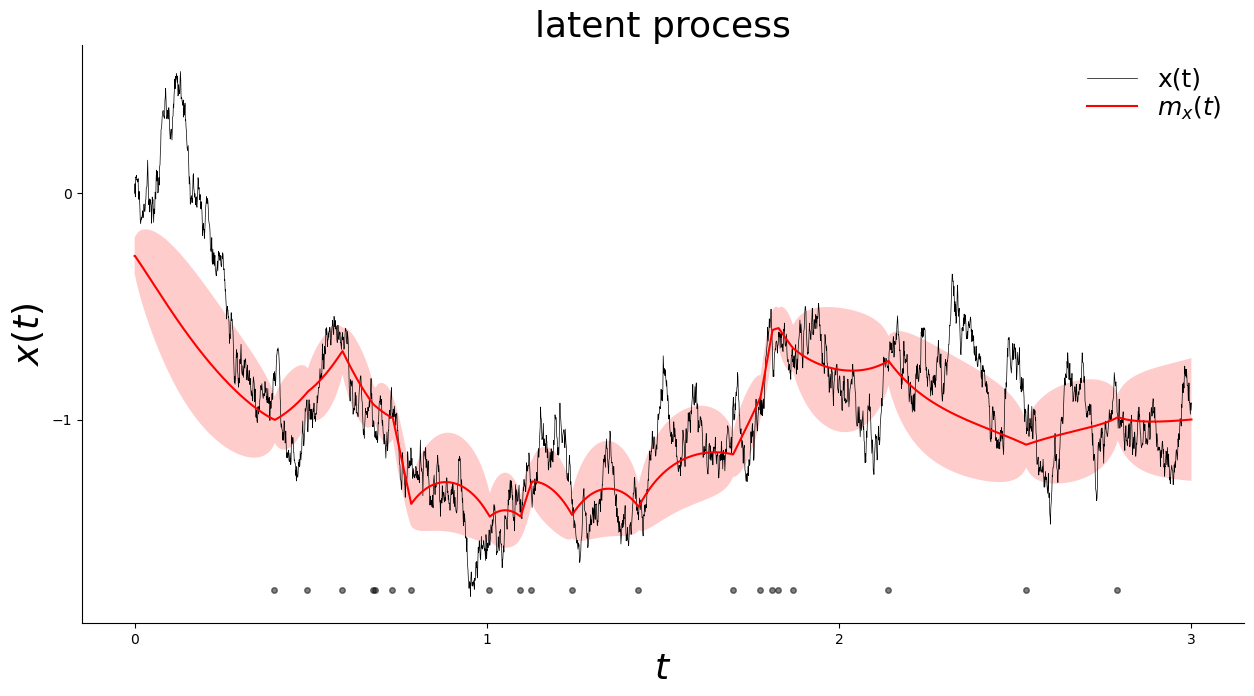

In [12]:
m, S = myGPSDE.inference.predict_marginals(idx, testTimes)

# plot the latent path 
f, ax = plt.subplots()
f.set_figheight(7.5)
f.set_figwidth(15)

ax.plot(testTimes.numpy(),xpath[idx],color='black',linewidth=0.5,label='x(t)')
ax.plot(testTimes.numpy(),m.squeeze().numpy(), color='red', label='$m_x(t)$')
ax.fill_between(testTimes.numpy(), m[:,0,0].numpy()+np.sqrt(S[:,0,0].numpy()), 
                m[:,0,0].squeeze().numpy()-np.sqrt(S[:,0,0].numpy()), facecolor='red', alpha=0.2)
ax.legend(fontsize=18,frameon=False,loc="best", labelspacing=0.1)

# plot where observatioins lie
ax.plot(tObs[idx],-1.75*np.ones_like(tObs[idx]),'k.',alpha=0.5, markersize=mkrsz+2)
ax.locator_params(nbins=4)
ax.set_ylabel('$x(t)$',fontsize=26)
ax.set_xlabel('$t$',fontsize=26)
ax.set_title('latent process',fontsize=26)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()

# Learnt drift function with fixed points, tangents and fixed point uncertainty

ValueError: yerr must be a scalar or a 1D or (2, n) array-like

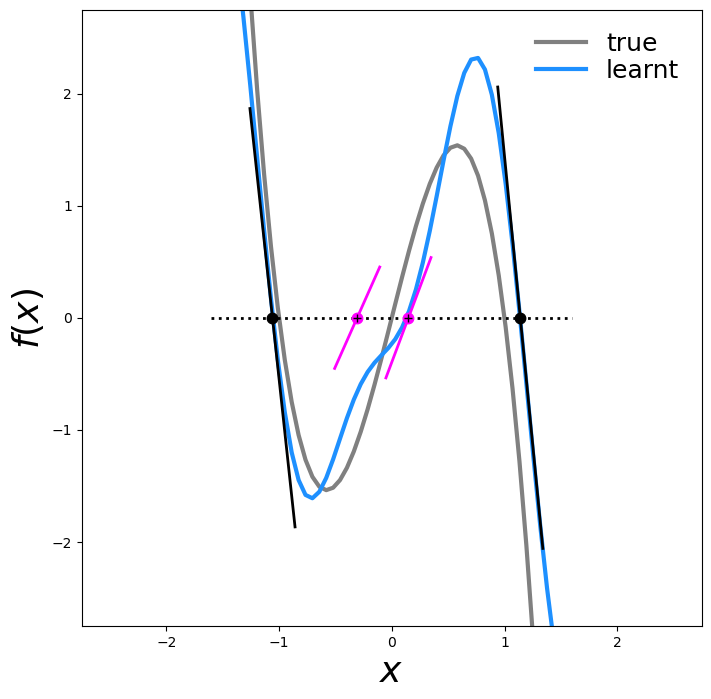

In [13]:
ngrid = 50
xmin = -1.5
xmax = 1.5

f, ax = plt.subplots()
f.set_figheight(8)
f.set_figwidth(8)

ax.plot(np.linspace(xmin,xmax,ngrid), doubleWell(np.linspace(xmin,xmax,ngrid)),linewidth=3,color='grey',label='true')
ax.plot(torch.linspace(xmin,xmax,ngrid).numpy(),myGPSDE.model.transfunc.predict(
    torch.linspace(xmin,xmax,ngrid).unsqueeze(-1).unsqueeze(0)).detach().squeeze().numpy(),linewidth=3,
         color='dodgerblue',label='learnt')

ax.plot([-1.6, 1.6],[0, 0], ':k',linewidth=2)

ax.set_xlim([-2.75, 2.75])
ax.set_ylim([-2.75, 2.75])
ax.set_xlabel('$x$',fontsize=26)
ax.set_ylabel('$f(x)$',fontsize=26)

ax.legend(fontsize=18,frameon=False,loc="best", labelspacing=0.1)

h = 0.2
for a in range(myGPSDE.model.transfunc.numFx):
    fx = myGPSDE.model.transfunc.Zs_fx.detach().numpy()[a]
    Jfx = myGPSDE.model.transfunc.q_Jfx.detach().numpy()[a]
    if Jfx > 0:
        ax.plot(myGPSDE.model.transfunc.Zs_fx[a,0].detach().numpy(), 
         torch.zeros_like(myGPSDE.model.transfunc.Zs_fx[a,0]).numpy(),'.',markersize=15,color='magenta')
        ax.plot([fx-h, fx, fx+h], Jfx * [-h, 0, h], linewidth=2,color='magenta')
    else:
        ax.plot(myGPSDE.model.transfunc.Zs_fx[a,0].detach().numpy(), 
         torch.zeros_like(myGPSDE.model.transfunc.Zs_fx[a,0]).numpy(),'.',markersize=15,color='black')

        ax.plot([fx-h, fx, fx+h], Jfx * [-h, 0, h], linewidth=2,color='black')

ax.errorbar(myGPSDE.model.transfunc.Zs_fx.detach().numpy(),torch.zeros_like(myGPSDE.model.transfunc.Zs_fx).numpy(),
            yerr = myGPSDE.model.transfunc.Zs_fx_sqrt.abs().detach().numpy(),
            fmt='+',color='black' ,ecolor='lightgray', elinewidth=3, capsize=10)
ax.locator_params(nbins=3)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.show()